In [202]:
import numpy as np
from typing import Sequence, Optional, Dict, Any, Tuple, List
from gurobipy import Model, GRB, LinExpr

# ---------- Scaling ----------
def _scale_matrix(X: np.ndarray, mode: Optional[str]) -> Tuple[np.ndarray, Dict[str, Any]]:
    """
    Column-wise scaling.
    mode in {None, 'minmax', 'sym', 'zscore'}:
      - minmax/unitrange: [0,1]
      - sym: [-1,1]
      - zscore: (x-mean)/std (breaks built on observed min/max of z)
    """
    X = np.asarray(X, dtype=float)
    n, m = X.shape
    meta = {"mode": mode, "params": []}
    if mode is None:
        return X.copy(), meta

    Xs = np.empty_like(X)
    for j in range(m):
        col = X[:, j].astype(float)
        if mode in ("minmax", "unitrange"):
            mn, mx = float(col.min()), float(col.max())
            rng = mx - mn if mx > mn else 1.0
            Xs[:, j] = (col - mn) / rng
            meta["params"].append({"min": mn, "max": mx})
        elif mode == "sym":
            mn, mx = float(col.min()), float(col.max())
            rng = mx - mn if mx > mn else 1.0
            Xs[:, j] = 2.0 * (col - mn) / rng - 1.0
            meta["params"].append({"min": mn, "max": mx})
        elif mode == "zscore":
            mu, sd = float(col.mean()), float(col.std(ddof=0))
            sd = sd if sd > 0 else 1.0
            Xs[:, j] = (col - mu) / sd
            meta["params"].append({"mean": mu, "std": sd})
        else:
            raise ValueError("Unknown scaling mode.")
    return Xs, meta


def _build_breaks(minv: float, maxv: float, L: int) -> np.ndarray:
    if L < 2:
        raise ValueError("L must be >= 2.")
    return np.linspace(minv, maxv, L)


def _interp_expr(m: Model, x: float, brk: np.ndarray, uvars: List[Any]) -> LinExpr:
    """
    Linear interpolation of u(x) over breakpoints brk and decision values uvars.
    Returns a Gurobi affine expression.
    """
    if x <= brk[0]:
        return LinExpr(uvars[0])
    if x >= brk[-1]:
        return LinExpr(uvars[-1])

    j = np.searchsorted(brk, x) - 1
    j = max(0, min(j, len(brk)-2))
    x0, x1 = float(brk[j]), float(brk[j+1])
    w1 = (x - x0) / (x1 - x0)
    w0 = 1.0 - w1
    expr = LinExpr()
    expr.addTerms([w0, w1], [uvars[j], uvars[j+1]])
    return expr


# ---------- Ground truth generator ----------
def uta_gt(
    X: np.ndarray,
    L: int,
    seed: Optional[int] = None,
    weights_dirichlet_alpha: float = 1.0,
    increments_dirichlet_alpha: float = 1.0,
    scale: Optional[str] = "minmax",
) -> Dict[str, Any]:
    """
    Generate a monotone↑ additive model:
      - weights w ~ Dirichlet(alpha)
      - each marginal u_k is PWL with L points; increments ~ Dirichlet => monotone; u_k(min)=0, u_k(max)=1
      - score(a) = sum_k w_k * u_k(x_ak)
    Returns weights, u_values (m x L), breaks, scores, and a strict order (best→worst).
    """
    rng = np.random.default_rng(seed)
    X = np.asarray(X, dtype=float)
    n, m = X.shape

    Xs, scale_info = _scale_matrix(X, scale)
    breaks = [_build_breaks(Xs[:, j].min(), Xs[:, j].max(), L) for j in range(m)]

    w = rng.dirichlet(np.full(m, weights_dirichlet_alpha))
    u_values = np.zeros((m, L))
    for j in range(m):
        inc = rng.dirichlet(np.full(L-1, increments_dirichlet_alpha))
        u_values[j, 0] = 0.0
        u_values[j, 1:] = np.cumsum(inc)  # ends at 1.0

    scores = np.zeros(n)
    for a in range(n):
        s = 0.0
        for j in range(m):
            x = float(Xs[a, j]); brk = breaks[j]
            if x <= brk[0]:
                u = u_values[j, 0]
            elif x >= brk[-1]:
                u = u_values[j, -1]
            else:
                t = np.searchsorted(brk, x) - 1
                t = max(0, min(t, L-2))
                lam = (x - brk[t]) / (brk[t+1] - brk[t])
                u = (1 - lam) * u_values[j, t] + lam * u_values[j, t+1]
            s += w[j] * u
        scores[a] = s

    order = np.argsort(-scores).tolist()
    return {
        "scale_info": scale_info,
        "breaks": breaks,
        "u_values": u_values,
        "weights": w,
        "scores": scores,
        "ranking": order,   # strict best→worst
    }


# ---------- UTA inference ----------
def uta_inf(
    X: np.ndarray,
    order: Optional[Sequence[int]],
    L: int,
    scale: Optional[str] = "minmax",
    eps: float = 1e-2,
    min_increment: float = 0.0,
    assume_rows_are_ordered: bool = False,
    gurobi_params: Optional[Dict[str, Any]] = None,
    verbose: bool = False,
) -> Dict[str, Any]:
    """
    Infer monotone↑ PWL marginals + additive weights from a **strict order** (no ties).

    Inputs
    ------
    X : (n, m) array
    order : sequence of indices best→worst, length n (strict). If None and
            assume_rows_are_ordered=True, we use order = [0,1,...,n-1].
    L : number of breakpoints per marginal (same for all criteria)
    scale : scaling mode ('minmax' default)
    eps : separation margin between adjacent ranks (after scaling)
    min_increment : minimal increment u[j,l+1] - u[j,l] ≥ min_increment (>=0)
    assume_rows_are_ordered : if True and order is None, row order is taken as the strict order
    gurobi_params : optional solver params dict
    verbose : print Gurobi logs if True

    Model
    -----
    - Variables u_{j,l} ≥ 0, monotone increasing; u_{j,0} = 0; sum_j u_{j,L-1} = 1 (=> weights = u_{j,L-1})
    - Utility U(a) = sum_j interp(u_j, x_aj)
    - Strict order via **adjacent** constraints only:
        For k=0..n-2 (order[k] must be preferred to order[k+1]):
            U(order[k]) - U(order[k+1]) ≥ eps + o[order[k+1]] - o[order[k]]
      where o[a] ≥ 0 are slacks minimized in the objective.
    - Objective: minimize sum_a o[a].

    Returns
    -------
    dict with: status, obj, scores, order (strict), breaks, u_values (m,L), weights (m,), scale_info
    """
    X = np.asarray(X, dtype=float)
    n, m = X.shape

    if order is None:
        if not assume_rows_are_ordered:
            raise ValueError("Provide a strict 'order' or set assume_rows_are_ordered=True.")
        order = list(range(n))
    else:
        order = list(order)
        if len(order) != n or len(set(order)) != n:
            raise ValueError("`order` must be a permutation of range(n) with no duplicates (strict).")

    Xs, scale_info = _scale_matrix(X, scale)
    breaks = [_build_breaks(Xs[:, j].min(), Xs[:, j].max(), L) for j in range(m)]

    model = Model("UTA_infer_strict")
    if not verbose:
        model.setParam("OutputFlag", 0)
    if gurobi_params:
        for k, v in gurobi_params.items():
            model.setParam(k, v)

    # u_{j,l}
    u = []
    for j in range(m):
        uj = [model.addVar(lb=0.0, name=f"u_{j}_{l}") for l in range(L)]
        u.append(uj)
    # slacks
    o = [model.addVar(lb=0.0, name=f"o_{a}") for a in range(n)]
    model.update()

    # Monotonicity
    for j in range(m):
        model.addConstr(u[j][0] == 0.0, name=f"norm_min_{j}")
        for l in range(L-1):
            model.addConstr(u[j][l+1] - u[j][l] >= min_increment, name=f"mono_{j}_{l}")

    # Sum of maxima = 1  -> weights = u[j][-1]
    model.addConstr(sum(u[j][-1] for j in range(m)) == 1.0, name="sum_weights")

    # Utilities
    U = []
    for a in range(n):
        expr = LinExpr()
        for j in range(m):
            expr += _interp_expr(model, float(Xs[a, j]), breaks[j], u[j])
        U.append(expr)

    # Strict order via adjacent pairs
    for k in range(n - 1):
        a, b = order[k], order[k + 1]
        model.addConstr(U[a] - U[b] >= eps + o[b] - o[a], name=f"adj_strict_{a}_{b}")

    model.setObjective(sum(o), GRB.MINIMIZE)
    model.optimize()

    status = model.Status
    if status not in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
        return {"status": status, "message": "Model not optimal/suboptimal."}

    u_values = np.array([[u[j][l].X for l in range(L)] for j in range(m)])
    weights = u_values[:, -1].copy()
    scores = np.array([U[a].getValue() for a in range(n)])
    inferred_order = np.argsort(-scores).tolist()

    return {
        "status": status,
        "obj": model.ObjVal,
        "scores": scores,
        "ranking": inferred_order,     # strict best→worst
        "breaks": breaks,
        "u_values": u_values,
        "weights": weights,
        "scale_info": scale_info,
    }


In [203]:
# Number of alternatives and criteria
n, m = 100, 4

# Number of breakpoints per criterion
L = 5

# Generate n alternatives with m criteria with values between 0 and 1000
X = np.random.randint(0, 1000, size=(n,m))

# 1) Generate ground truth
gt = uta_gt(X, L=L, seed=42)
ranking_ref = gt["ranking"]   # classes [[best], [second], ..., [worst]]
print("ranking_ref (top 10):", ranking_ref[:10])
print("Ground truth weights:", np.round(gt["weights"], 4))
    
# 2) Infer
res = uta_inf(X, order=ranking_ref, L=L, eps=0.0001)

print("Status:", res["status"])
print("Obj (∑o):", res["obj"])
print("Weights:", np.round(res["weights"], 4))
print("Ranking (top 10):", res["ranking"][:10])

ranking_ref (top 10): [84, 29, 11, 25, 47, 52, 90, 10, 70, 81]
Ground truth weights: [0.3247 0.3155 0.322  0.0378]
Status: 2
Obj (∑o): 0.0
Weights: [0.3252 0.3174 0.3208 0.0366]
Ranking (top 10): [84, 29, 11, 25, 47, 52, 90, 10, 70, 81]


In [204]:
import numpy as np
import matplotlib.pyplot as plt

def plot_value_functions(gt: dict, res: dict, mode: str = "weighted"):
    """
    Plot piecewise-linear value functions (True vs Inferred) in a 2-column grid.

    Parameters
    ----------
    gt, res : dict
        Expect:
          gt["breaks"]   : list of arrays (len = m)
          gt["u_values"] : (m, L_gt)
          gt["weights"]  : (m,)
          res["breaks"]  : list of arrays (len = m)
          res["u_values"]: (m, L_inf)
          res["weights"] : (m,)
    mode : {"weighted", "shape"}
        - "weighted": plot w_j * u_j(x) on both sides (directly comparable in level).
        - "shape":    normalize each marginal by its max (compare pure shapes).
    """
    m = len(gt["breaks"])
    if m != len(res["breaks"]):
        raise ValueError("Mismatch in number of criteria between GT and inferred.")

    rows = (m + 1) // 2
    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(11, 3*rows))
    axes = np.ravel(axes) if rows > 1 else np.array([axes]).ravel()

    for j, ax in enumerate(axes[:m]):
        # True
        x_true = np.asarray(gt["breaks"][j], float)
        u_true = np.asarray(gt["u_values"][j], float)
        # Inferred
        x_inf  = np.asarray(res["breaks"][j], float)
        u_inf  = np.asarray(res["u_values"][j], float)

        if mode == "weighted":
            w_t = float(gt["weights"][j])
            w_i = float(res["weights"][j])
            y_true = w_t * u_true
            y_inf  = w_i * u_inf
            y_label = r"$w_j \cdot u_j(x)$"
            title_suffix = "Weighted"
        elif mode == "shape":
            # normalize by each marginal’s max (avoid divide-by-zero)
            y_true = u_true / (u_true[-1] if u_true[-1] > 0 else 1.0)
            y_inf  = u_inf  / (u_inf[-1]  if u_inf[-1]  > 0 else 1.0)
            y_label = "Normalized partial utility"
            title_suffix = "Shape"
        else:
            raise ValueError("mode must be 'weighted' or 'shape'.")

        # Plot (no explicit colors)
        ax.plot(x_true, y_true, marker='o', linewidth=2, label='True')
        ax.plot(x_inf,  y_inf,  marker='s', linestyle='--', linewidth=2, label='Inferred')

        # Cosmetics
        ax.set_title(f"C{j+1} ({title_suffix})")
        # x-axis is already in scaled units (e.g., [0,1]); show 0..1 or 0..100 as you prefer:
        ax.set_xlim(x_true.min(), x_true.max())
        # Robust y-limit
        ymax = max(y_true.max(), y_inf.max()) if y_true.size and y_inf.size else 1.0
        ax.set_ylim(0, 1.1 * ymax if ymax > 0 else 1.0)

        ax.set_xlabel("Criterion value (scaled x)")
        ax.set_ylabel(y_label)
        ax.grid(True)
        ax.legend()

    # Hide any extra axes if m is odd
    for ax in axes[m:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def plot_weights(gt: dict, res: dict):
    """
    Side-by-side bar plot of True vs Inferred weights.
    """
    w_true = np.asarray(gt["weights"], float)
    w_inf  = np.asarray(res["weights"], float)
    if w_true.shape != w_inf.shape:
        raise ValueError("Weight vectors have different shapes.")

    m = len(w_true)
    idx = np.arange(m)
    barw = 0.35

    plt.figure(figsize=(7, 3))
    plt.bar(idx - barw/2, w_true, width=barw, label="True")
    plt.bar(idx + barw/2, w_inf,  width=barw, label="Inferred")
    plt.xticks(idx, [f"C{i+1}" for i in range(m)])
    plt.xlabel("Criterion")
    plt.ylabel("Weight")
    plt.title("Weights: True vs Inferred")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


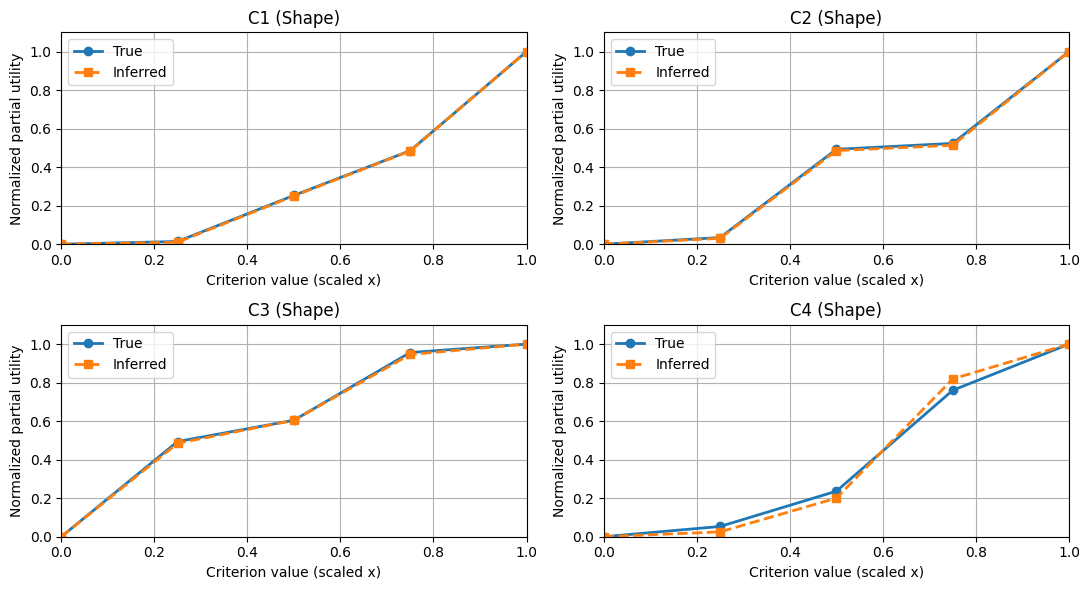

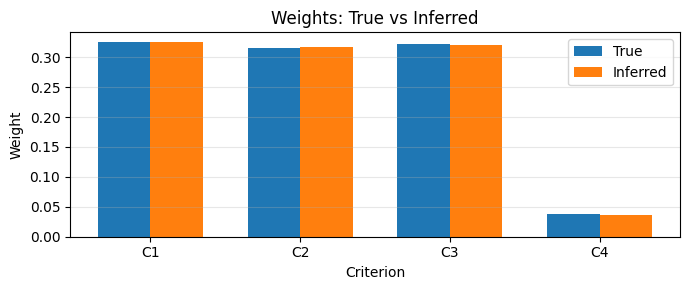

In [205]:
# Example (after you computed gt = uta_gt(...), res = uta_infer_strict(...))
plot_value_functions(gt, res, mode="shape")  # or mode="shape"
plot_weights(gt, res)


In [ ]:
import numpy as np

# --- scaling cohérent avec model["scale_info"] ---
def _scale_with_info(X, scale_info):
    mode = scale_info.get("mode")
    if not mode: 
        return X
    X = np.asarray(X, dtype=float).copy()
    params = scale_info["params"]
    for j in range(X.shape[1]):
        if mode in ("minmax", "unitrange"):
            mn, mx = params[j]["min"], params[j]["max"]
            rng = (mx - mn) if mx > mn else 1.0
            X[:, j] = (X[:, j] - mn) / rng
        elif mode == "sym":
            mn, mx = params[j]["min"], params[j]["max"]
            rng = (mx - mn) if mx > mn else 1.0
            X[:, j] = 2.0 * (X[:, j] - mn) / rng - 1.0
        elif mode == "zscore":
            mu, sd = params[j]["mean"], params[j]["std"]
            sd = sd if sd > 0 else 1.0
            X[:, j] = (X[:, j] - mu) / sd
        else:
            raise ValueError("Unknown scaling mode in scale_info.")
    return X

# --- scoreur à partir des clés 'weights' / 'u_values' / 'breaks' / 'scale_info' ---
def make_scoring_fn(model):
    w = np.asarray(model["weights"])          # (m,)
    uvals = np.asarray(model["u_values"])     # (m, L)
    brks  = model["breaks"]                   # list of m arrays (L,)
    sinfo = model.get("scale_info", {"mode": None})

    # interpolation 1D vectorisée par critère
    def U(X):
        X = np.atleast_2d(X).astype(float)
        Xs = _scale_with_info(X, sinfo)

        scores = np.zeros(X.shape[0])
        for j in range(X.shape[1]):
            # interpolation 1D → u_j(a_j)
            uj = np.interp(Xs[:, j], brks[j], uvals[j])
            scores += w[j] * uj
        return scores

    return U

# --- un run: GT -> INF -> 10k paires -> accord ---
def pairwise_agreement_once(n=100, m=4, L=5, n_pairs=10_000, seed=None):
    rng = np.random.default_rng(seed)

    # échantillon pour construire GT/INF
    X = rng.integers(0, 1000, size=(n, m))

    # GT
    gt = uta_gt(X, L=L, seed=int(rng.integers(0, 1_000_000)))
    U_gt = make_scoring_fn(gt)
    ranking_ref = gt["ranking"]  # strict best→worst (indices)

    # INF
    inf = uta_inf(X, order=ranking_ref, L=L, eps=1e-4)
    U_inf = make_scoring_fn(inf)

    # 10k paires (x,y) tirées indépendamment de X (0..1000), puis scorées avec scaling du modèle
    XY = rng.integers(0, 1000, size=(n_pairs, 2, m))
    Xp, Yp = XY[:, 0, :], XY[:, 1, :]

    cmp_gt  = np.sign(U_gt(Xp) - U_gt(Yp))   # -1 / +1
    cmp_inf = np.sign(U_inf(Xp) - U_inf(Yp))

    return float((cmp_gt == cmp_inf).mean())

# --- protocole complet: 30 répétitions ---
def run_protocol(n=100, m=4, L=5, n_pairs=10_000, repeats=30, seed=42):
    rng = np.random.default_rng(seed)
    accs = [
        pairwise_agreement_once(n=n, m=m, L=L, n_pairs=n_pairs, 
                                seed=int(rng.integers(0, 1_000_000)))
        for _ in range(repeats)
    ]
    accs = np.array(accs)
    return {
        "mean_acc": float(accs.mean()),
        "std_acc":  float(accs.std(ddof=1)),
        "runs": repeats,
        "per_run": accs.tolist(),
    }

In [267]:
res = run_protocol(n=100, m=4, L=5, n_pairs=10_000, repeats=30)
print(f"Pairwise agreement (n=100, 30 runs): {res['mean_acc']:.3%}") 
res = run_protocol(n=250, m=4, L=5, n_pairs=10_000, repeats=30)
print(f"Pairwise agreement (n=250, 30 runs): {res['mean_acc']:.3%}")
res = run_protocol(n=500, m=4, L=5, n_pairs=10_000, repeats=30)
print(f"Pairwise agreement (n=500, 30 runs): {res['mean_acc']:.3%}")

GT pairwise: 5020 negative, 4980 positive comparisons.
GT pairwise: 4953 negative, 5047 positive comparisons.
GT pairwise: 5072 negative, 4928 positive comparisons.
GT pairwise: 4978 negative, 5022 positive comparisons.
GT pairwise: 5042 negative, 4958 positive comparisons.
GT pairwise: 5039 negative, 4961 positive comparisons.
GT pairwise: 4943 negative, 5057 positive comparisons.
GT pairwise: 4980 negative, 5020 positive comparisons.
GT pairwise: 4998 negative, 5002 positive comparisons.
GT pairwise: 4996 negative, 5004 positive comparisons.
GT pairwise: 4906 negative, 5094 positive comparisons.
GT pairwise: 5008 negative, 4992 positive comparisons.
GT pairwise: 4960 negative, 5040 positive comparisons.
GT pairwise: 4993 negative, 5007 positive comparisons.
GT pairwise: 4962 negative, 5038 positive comparisons.
GT pairwise: 5021 negative, 4979 positive comparisons.
GT pairwise: 4972 negative, 5028 positive comparisons.
GT pairwise: 4985 negative, 5015 positive comparisons.
GT pairwis